Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# all imports needed for this sheet

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline
import seaborn as sns
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [3]:
!pip install matplotlib==3.1.0

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
# Split train into train & val
target = 'status_group'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)


In [0]:
# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [153]:
%matplotlib inline
import category_encoders as ce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        #X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    #duplicates = ['quantity_group', 'payment_type']
    #X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies)
    unusable_variance = ['recorded_by', 'num_private']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    #X['years_MISSING'] = X['years'].isnull()

    # Engineer feature: height of well is 1500 or lower
    X['lower_height'] = X['gps_height'] <= 1500

    # Engineer feature: year recorded 2012 or later
    #X['post_2012_rec'] = X['year_recorded'] >= 2012

    # Engineer feature: constructed 2000 or later
    #X['not_old'] = X['construction_year'] >= 2000

    # Engineer feature: funder is in top 5 funders
    # Get a list of the top 5 neighborhoods
    top1 = train['management'].value_counts()[:1].index
    X['top_1_manager'] = X['management'].isin(top1)

    # Engineer feature: funder is top funder:
    #topfund = train['funder'].value_counts()[:1].index
    #X['top_funder'] = X['funder'].isin(topfund)
    
    # return the wrangled dataframe
    return X




# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train & val. Make val the same size as test.
target = 'status_group'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)

# Wrangle train, validate, and test sets in the same way
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

# Make pipeline!
pipeline = make_pipeline(
    #ce.OneHotEncoder(use_cat_names=True, cols=['public_meeting'
     #                                          ]),
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='most_frequent'), 
    RandomForestClassifier(n_estimators = 210,
                          min_samples_leaf = 1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8155035520267446


In [154]:
k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='accuracy')
print(f'MAE for {k} folds:', -scores)

MAE for 3 folds: [-0.798002   -0.80205142 -0.80343702]


In [155]:
-scores.mean()

-0.8011634793087173

In [156]:
print('Model Hyperparameters:')
print(pipeline.named_steps['randomforestclassifier'])

Model Hyperparameters:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=210,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [0]:
%matplotlib inline
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier()
)

depth = range(100, 301, 100)
train_scores, val_scores = validation_curve(
    pipeline, X_train, y_train,
    param_name='randomforestclassifier__n_estimators', 
    param_range=depth, scoring='accuracy', 
    cv=3,
    n_jobs=1
)

plt.figure(dpi=150)
plt.plot(depth, np.mean(-train_scores, axis=1), color='blue', label='training error')
plt.plot(depth, np.mean(-val_scores, axis=1), color='red', label='validation error')
plt.title('Validation Curve')
plt.xlabel('model complexity: RandomForestClassifier max_depth')
plt.ylabel('model score: Accuracy')
plt.legend();

In [0]:
# convert integers in target column to strings for use in kaggle submission

train['status_group'] = train['status_group'].replace('functional', 1)
train['status_group'] = train['status_group'].replace('non functional', 2)
train['status_group'] = train['status_group'].replace('functional needs repair', 3)



In [123]:
from scipy.stats import randint, uniform

features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]

pipeline = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(random_state=42)
)

param_distributions = {
    'targetencoder__min_samples_leaf': randint(1, 1000), 
     
    'simpleimputer__strategy': ['most_frequent', 'mean', 'median'], 
    'randomforestclassifier__n_estimators': 100, 
    'randomforestclassifier__max_depth': [20, 30, 40, None], 
    
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=4, 
    cv=2, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=1
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 3 candidates, totalling 6 fits
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__n_estimators=300, simpleimputer__strategy=most_frequent, targetencoder__min_samples_leaf=33 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__n_estimators=300, simpleimputer__strategy=most_frequent, targetencoder__min_samples_leaf=33, score=(train=1.000, test=0.793), total=  18.5s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__n_estimators=300, simpleimputer__strategy=most_frequent, targetencoder__min_samples_leaf=33 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.6s remaining:    0.0s


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__n_estimators=300, simpleimputer__strategy=most_frequent, targetencoder__min_samples_leaf=33, score=(train=1.000, test=0.796), total=  18.1s
[CV] randomforestclassifier__max_depth=20, randomforestclassifier__n_estimators=150, simpleimputer__strategy=most_frequent, targetencoder__min_samples_leaf=380 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   40.9s remaining:    0.0s


[CV]  randomforestclassifier__max_depth=20, randomforestclassifier__n_estimators=150, simpleimputer__strategy=most_frequent, targetencoder__min_samples_leaf=380, score=(train=0.963, test=0.795), total=   8.9s
[CV] randomforestclassifier__max_depth=20, randomforestclassifier__n_estimators=150, simpleimputer__strategy=most_frequent, targetencoder__min_samples_leaf=380 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   50.9s remaining:    0.0s


[CV]  randomforestclassifier__max_depth=20, randomforestclassifier__n_estimators=150, simpleimputer__strategy=most_frequent, targetencoder__min_samples_leaf=380, score=(train=0.961, test=0.795), total=   8.9s
[CV] randomforestclassifier__max_depth=30, randomforestclassifier__n_estimators=250, simpleimputer__strategy=most_frequent, targetencoder__min_samples_leaf=155 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.0min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=30, randomforestclassifier__n_estimators=250, simpleimputer__strategy=most_frequent, targetencoder__min_samples_leaf=155, score=(train=1.000, test=0.793), total=  15.2s
[CV] randomforestclassifier__max_depth=30, randomforestclassifier__n_estimators=250, simpleimputer__strategy=most_frequent, targetencoder__min_samples_leaf=155 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s


[CV]  randomforestclassifier__max_depth=30, randomforestclassifier__n_estimators=250, simpleimputer__strategy=most_frequent, targetencoder__min_samples_leaf=155, score=(train=1.000, test=0.794), total=  15.5s


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.6min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.6min finished


In [124]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation accuracy score', -search.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': 20, 'randomforestclassifier__n_estimators': 150, 'simpleimputer__strategy': 'most_frequent', 'targetencoder__min_samples_leaf': 380}
Cross-validation accuracy score -0.795057945917144


In [120]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation accuracy score', -search.best_score_)

NameError: ignored

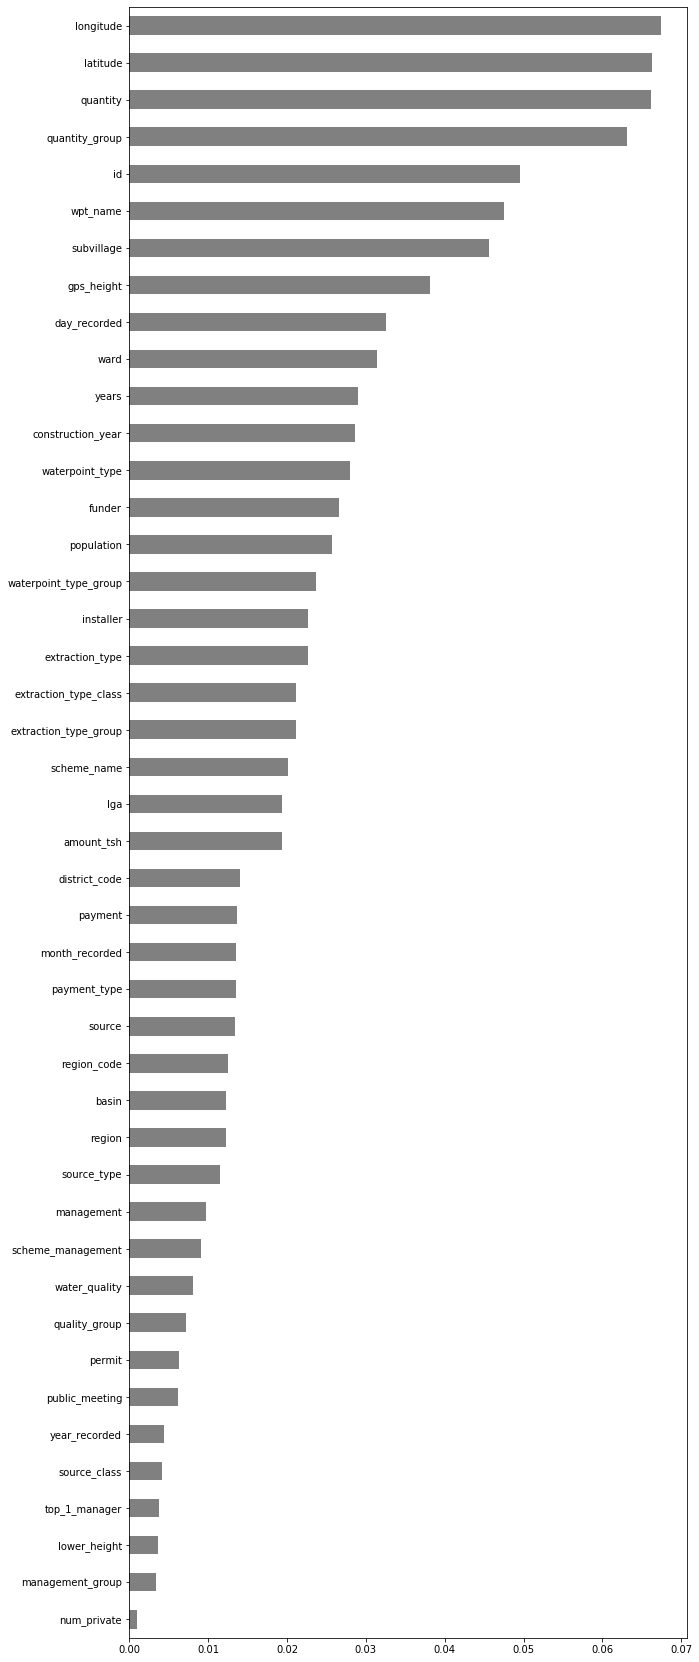

In [147]:
# Linear models have coefficients whereas decision trees have "Feature Importances"
import matplotlib.pyplot as plt

model = pipeline.named_steps['randomforestclassifier']
encoder = pipeline.named_steps['ordinalencoder']
encoded_columns = encoder.transform(X_val).columns
importances = pd.Series(model.feature_importances_, encoded_columns)
plt.figure(figsize=(10,30))
importances.sort_values().plot.barh(color='grey')

In [76]:
train.columns

Index(['id', 'amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group', 'status_group',
       'year_recorded', 'month_recorded', 'day_recorded', 'years',
       'lower_height'],
      dtype='object')

In [96]:
train['management'].value_counts()

vwc                 30782
wug                  4912
water board          2209
wua                  1952
private operator     1487
parastatal           1309
water authority       697
other                 637
company               500
unknown               425
other - school         73
trust                  59
Name: management, dtype: int64

In [72]:
y_pred = pipeline.predict(X_test) 
# make submission

submission = test[['id']].copy()
submission['status_group'] = y_pred
# submission['status_group']
submission.to_csv('waterpump-submission-28.csv', index=False)

sub_df = pd.read_csv('/content/waterpump-submission-28.csv')

sub_df.shape

(14358, 2)

In [59]:
# Compute the confusion_matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[7026,  159,  613],
       [ 555,  316,  172],
       [1149,   64, 4304]])

In [60]:
# Get the unique labels
from sklearn.utils.multiclass import unique_labels
unique_labels(y_val)

array(['functional', 'functional needs repair', 'non functional'],
      dtype='<U23')

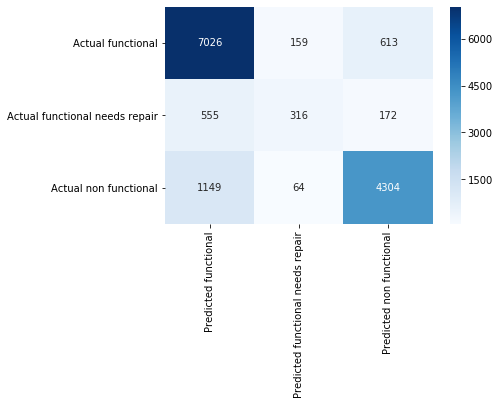

In [61]:
def plot_confusion_matrix(y_true, y_pred):
  labels = unique_labels(y_true)
  columns = [f'Predicted {label}' for label in labels]
  index = [f'Actual {label}' for label in labels]
  df = pd.DataFrame(confusion_matrix(y_true, y_pred),
                    columns = columns,
                    index = index)
  return sns.heatmap(df, annot=True, fmt='d', cmap='Blues')

plot_confusion_matrix(y_val, y_pred);

In [12]:
!pip install scikit-plot

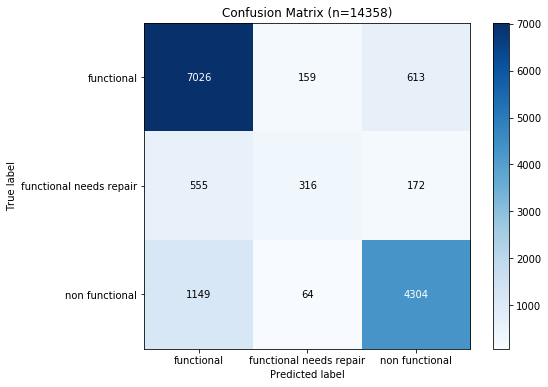

In [62]:
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(y_val, y_pred, 
                                    figsize=(8,6),
                                    title=f'Confusion Matrix (n={len(y_val)})',
                                    normalize=False);

In [63]:
7026 + 316 + 4304

11646

In [64]:
len(y_val)

14358

In [65]:
11646/14358

0.8111157542833264

In [66]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.80      0.90      0.85      7798
functional needs repair       0.59      0.30      0.40      1043
         non functional       0.85      0.78      0.81      5517

               accuracy                           0.81     14358
              macro avg       0.75      0.66      0.69     14358
           weighted avg       0.80      0.81      0.80     14358



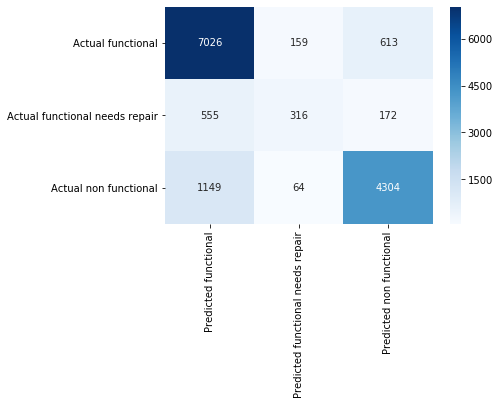

In [67]:
plot_confusion_matrix(y_val, y_pred);

In [0]:
correct_non_functional = 4315

In [0]:
total_pred_non_functional = 4315 + 169 + 640

In [35]:
precision_non_functional = correct_non_functional/total_pred_non_functional
precision_non_functional

0.8421155347384855

In [0]:
total_actual_non_functional = 1138 + 64 + 4315

In [37]:
correct_non_functional/total_actual_non_functional

0.7821279680986043

In [38]:
y_train.value_counts(normalize=True)

functional                 0.543071
non functional             0.384241
functional needs repair    0.072688
Name: status_group, dtype: float64

In [39]:
y_train = y_train != 'functional'
y_val = y_val != 'functional'
y_train.value_counts(normalize=True)

False    0.543071
True     0.456929
Name: status_group, dtype: float64

In [40]:
len(val) == len(test)

True

In [0]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

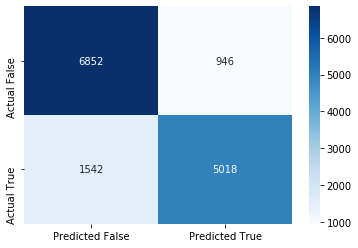

In [42]:
plot_confusion_matrix(y_val, y_pred);

In [44]:
946 + 5018

5964

In [45]:
# Discrete binary predictions...
y_pred

array([ True,  True, False, ..., False, False, False])

In [46]:
# Predicted probabilities for positive class
pipeline.predict_proba(X_val)[:, 1]

array([0.99, 0.71, 0.08, ..., 0.1 , 0.48, 0.02])

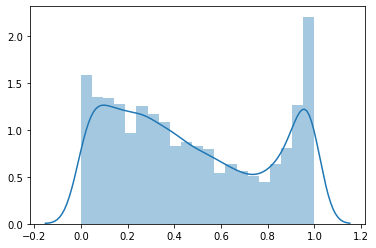

In [47]:
y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
sns.distplot(y_pred_proba);

False    12259
True      2099
dtype: int64

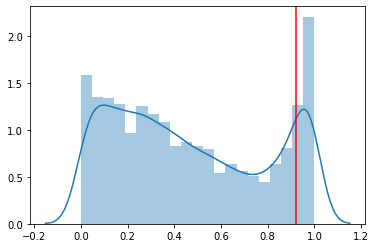

In [48]:
threshold = 0.92

y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
y_pred = y_pred_proba > threshold

ax = sns.distplot(y_pred_proba)
ax.axvline(threshold, color='red')

pd.Series(y_pred).value_counts()

In [49]:
from ipywidgets import interact, fixed

def set_threshold(y_true, y_pred_proba, threshold=0.5):
  y_pred = y_pred_proba > threshold

  ax = sns.distplot(y_pred_proba)
  ax.axvline(threshold, color='red');
  plt.show()
  print(classification_report(y_true, y_pred))
  plot_confusion_matrix(y_true, y_pred)

interact(set_threshold,
         y_true=fixed(y_val),
         y_pred_proba=fixed(y_pred_proba), 
         threshold=(0, 1, 0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

<function __main__.set_threshold>

In [50]:
results = pd.DataFrame({'y_val': y_val, 'y_pred_proba': y_pred_proba})
top2000 = results.sort_values(by='y_pred_proba', ascending=False)[:2000]
top2000

,y_val,y_pred_proba
10792,True,1.00
56501,True,1.00
1263,True,1.00
3337,True,1.00
51183,True,1.00
...,...,...
17709,True,0.93
54709,True,0.93
10635,False,0.93
18296,True,0.93


In [51]:
top2000.sample(n=50)

,y_val,y_pred_proba
28208,True,0.99
15746,True,0.93
32398,True,1.00
39337,True,0.99
14303,True,0.98
20845,True,0.99
11989,True,0.95
56465,True,0.93
43296,True,0.99
45595,True,0.96


In [52]:
trips = 2000
print(f'Baseline: {trips * 0.46} waterpump repairs in {trips} trips')

relevant_recommendations = top2000['y_val'].sum()
print(f'With model: Predict {relevant_recommendations} waterpump repairs in {trips} trips')

Baseline: 920.0 waterpump repairs in 2000 trips
With model: Predict 1974 waterpump repairs in 2000 trips


In [53]:
precision_at_k_2000 = relevant_recommendations/trips
print('Precision @ k=2000', precision_at_k_2000)

Precision @ k=2000 0.987


In [0]:
# "The ROC curve is created by plotting the true positive rate (TPR) 
# against the false positive rate (FPR) 
# at various threshold settings."

# Use scikit-learn to calculate TPR & FPR at various thresholds
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

In [55]:
# See the results in a table
pd.DataFrame({
    'False Positive Rate': fpr, 
    'True Positive Rate': tpr, 
    'Threshold': thresholds
})

,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,2.00
1,0.000128,0.067530,1.00
2,0.000385,0.115701,0.99
3,0.000641,0.155335,0.98
4,0.001026,0.192378,0.97
...,...,...,...
97,0.888689,0.996951,0.04
98,0.915106,0.997713,0.03
99,0.943319,0.998628,0.02
100,0.969351,0.999695,0.01


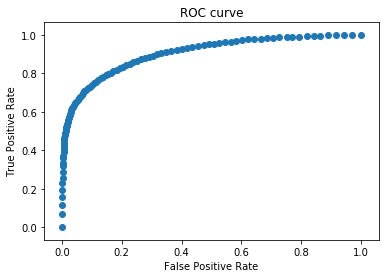

In [56]:
# See the results on a plot. 
# This is the "Receiver Operating Characteristic" curve
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [57]:
# Use scikit-learn to calculate the area under the curve.
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val, y_pred_proba)

0.9050500558304505